# Analytical calculations of the bias of the Lyman-alpha forest

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

### First, show that the formulae reproduce the bias value from https://arxiv.org/pdf/1205.2018.pdf appendix 1.

In [2]:
#Calculate tau and flux.

#delta range
y = np.linspace(-10.,10.,10**3+1)

#pdf
p = (1/np.sqrt(2*np.pi))*np.exp(-0.5*y*y)

#tau
a = 0.077
g = 2.16
tau = a*np.exp(g*y)

#flux
F = np.exp(-tau)
mean_F = np.trapz(F*p,y)

In [3]:
#Value found in paper.
print('Reference value:\n0.0925\n')

#Replicate equation A.6 (there is a - sign missing from the paper?)
#d(tau)/dy = gamma * tau(y)
bias_ratio2 = -(1/(mean_F**2))*(np.trapz(p*F*y,y))*(np.trapz(p*F*g*tau,y))
print('Eqn A.6:\n{:2.4f}\n'.format(bias_ratio2))

#The left hand integral from A.6 can be simplified using integration by parts:
#integral of y*p(y)*F(y) = integral of (dF(y)/dy)*p(y)
#This is now identical to the right hand integral.
#Check this gives the same results:
bias_ratio2 = (1/(mean_F**2))*((np.trapz(p*F*g*tau,y)))**2
print('Simplify left integral:\n{:2.4f}\n'.format(bias_ratio2))

#Due to the form of the lognormal transformation, we can complete the square with the gaussian pdf:
#p(y)*tau(y) = a*exp(0.5*gamma^2)*p(y-gamma)
#Calculate p_shift - the shifted pdf p(y-gamma) - and show this is still the same:
p_shift = (1/np.sqrt(2*np.pi))*np.exp(-0.5*(y-g)**2)
bias_ratio2 = (1/(mean_F**2))*(g*a*(np.exp(0.5*(g**2))*(np.trapz(p_shift*F,y))))**2
print('Complete the square with tau:\n{:2.4f}'.format(bias_ratio2))

Reference value:
0.0925

Eqn A.6:
0.0928

Simplify left integral:
0.0928

Complete the square with tau:
0.0928


### The formulae appear to work - define functions to evaluate the integrals

In [4]:
#In my definition (from CoLoRe), tau = a*np.exp(b*D*sG*delta - b*D^2*sG^2)
#The sG in multiplying the delta is different to CoLoRe: 
#here, delta is of variance 1 whereas the delta from CoLoRe has variance greater than 1

In [5]:
def get_tau(delta_G,a,b,sG,D,method=None):
    dG_ones = np.ones_like(delta_G)
    if method == 'FR12':
        tau = a*np.exp(delta_G*b*sG*D)
    else:
        tau = a*np.exp(delta_G*b*sG*D - 0.5*dG_ones*b*(D**2)*(sG**2))
    return tau

In [6]:
#Function to integrate F(y)*p(y) for input parameters a,b,sG and growth factor
#'shift' changes to F(y)*p(y-b*sG*D).
def F_integral(z,a,b,sG,D,shift=False,N_pow=3,tau_method=None):
    #Define the shift size
    centre = shift*(b*sG*D)
    #Define y, shift it if necessary
    y_initial = np.linspace(-10.,+10.,10**N_pow+1)
    y = np.add.outer(y_initial,centre)
    #Helpful variables
    y_ones = np.ones_like(y)
    #Define F, p and integrate
    tau = get_tau(y,a,b,sG,D,method=tau_method)
    F = np.exp(-tau)
    p = (1/np.sqrt(2*np.pi))*np.exp(-0.5*(y-centre)**2)
    integral = np.trapz(F*p,y,axis=0)
    return integral

In [7]:
#Function to integrate F(y)*p(y)*tau(y) for input parameters a,b,sG and growth factor
def F_tau_integral(z,a,b,sG,D,N_pow=3,tau_method=None):
    #Define y
    y_initial = np.linspace(-10.,+10.,10**N_pow+1)
    y = np.add.outer(y_initial,np.zeros(1))
    #Helpful variables
    y_ones = np.ones_like(y)
    #Define F, p and integrate
    tau = get_tau(y,a,b,sG,D,method=tau_method)
    F = np.exp(-tau)
    p = (1/np.sqrt(2*np.pi))*np.exp(-0.5*y**2)
    integral = np.trapz(F*p*tau,y,axis=0)
    return integral

In [8]:
#Function to integrate calculate the theoretical bias.
def theoretical_bias2(z,a,b,sG,D,q='flux',tau_method=None):
    if q=='gaussian':
        return np.ones(z.shape)
    if q=='density':
        return (D**2)
    if q=='tau':
        return (D**2)*(b**2)
    if q=='flux':
        return ((a*b*D)*np.exp(0.5*b*(D**2)*(sG**2)*(b-1)) * (F_integral(z,a,b,sG,D,shift=True,tau_method=tau_method))/(F_integral(z,a,b,sG,D,shift=False,tau_method=tau_method)))**2
    if q=='flux2':
        return (b*D*F_tau_integral(z,a,b,sG,D,tau_method=tau_method)/F_integral(z,a,b,sG,D,tau_method=tau_method))**2

In [9]:
#Show that the correct values from https://arxiv.org/pdf/1205.2018.pdf are still produced 
#(correcting for different definition of lognormal transformation)
z = 2.4
a = 0.077
#Set b*sG*d to match gamma=2.16
b = 2.16
sG = 1.0
d = 1.0
correction = np.exp(0.5*b*(d**2)*(sG**2))

#Value found in paper.
print('Reference value:\n0.0925\n')

#Method 1:
bias_ratio2 = theoretical_bias2(z,a,b,sG,d,q='flux',tau_method='FR12')*(correction)**2
print('Method 1:\n{:2.4f}\n'.format(bias_ratio2))

#Method 2:
bias_ratio2 = theoretical_bias2(z,a,b,sG,d,q='flux2',tau_method='FR12')
print('Method 2:\n{:2.4f}'.format(bias_ratio2[0]))

Reference value:
0.0925

Method 1:
0.0928

Method 2:
0.0928


### For different sets of tuning data, plot the predicted bias and mean flux

In [71]:
#Data from tuning with beta=1.65 (low)
tuning_blo = fits.open('../input_files/tuning_data_151118.fits')
z_blo = tuning_blo[1].data['z']
a_blo = tuning_blo[1].data['alpha']
b_blo = tuning_blo[1].data['beta']
sG_blo = tuning_blo[1].data['sigma_G']
tuning_blo.close()

#Data from tuning with beta=2.0 (high)
tuning_bhi = fits.open('../input_files/tuning_data_beta2.fits')
z_bhi = tuning_bhi[1].data['z']
a_bhi = tuning_bhi[1].data['alpha']
b_bhi = tuning_bhi[1].data['beta']
sG_bhi = tuning_bhi[1].data['sigma_G']
tuning_bhi.close()

#Fitting using a propto ((1+z)/(1+z0))^4.5, sigma_G fixed
a_test = 1.482*((1+z_blo)/(1+3.0))**4.5
b_test = np.ones_like(a_test)*1.65
sG_test = 6.054*((1+z_blo)/(1+3.0))**0.292

a_test_2 = 1.482*((1+z_blo)/(1+3.0))**(4.5 + 1.5)
b_test_2 = np.ones_like(a_test)*(1.650)
sG_test_2 = 6.054*((1+z_blo)/(1+3.0))**(0.292)

#Get D from the master file
m = fits.open('../example_data/lya_skewers/master.fits')
z = m[3].data['Z']
D = m[3].data['D']
m.close()

#Trim everything as the tuning z starts at lower z and ends at higher z than the master's
a_blo = np.interp(z,z_blo,a_blo)
b_blo = np.interp(z,z_blo,b_blo)
sG_blo = np.interp(z,z_blo,sG_blo)
a_bhi = np.interp(z,z_bhi,a_bhi)
b_bhi = np.interp(z,z_bhi,b_bhi)
sG_bhi = np.interp(z,z_bhi,sG_bhi)
a_test = np.interp(z,z_blo,a_test)
b_test = np.interp(z,z_blo,b_test)
sG_test = np.interp(z,z_blo,sG_test)
a_test_2 = np.interp(z,z_blo,a_test_2)
b_test_2 = np.interp(z,z_blo,b_test_2)
sG_test_2 = np.interp(z,z_blo,sG_test_2)

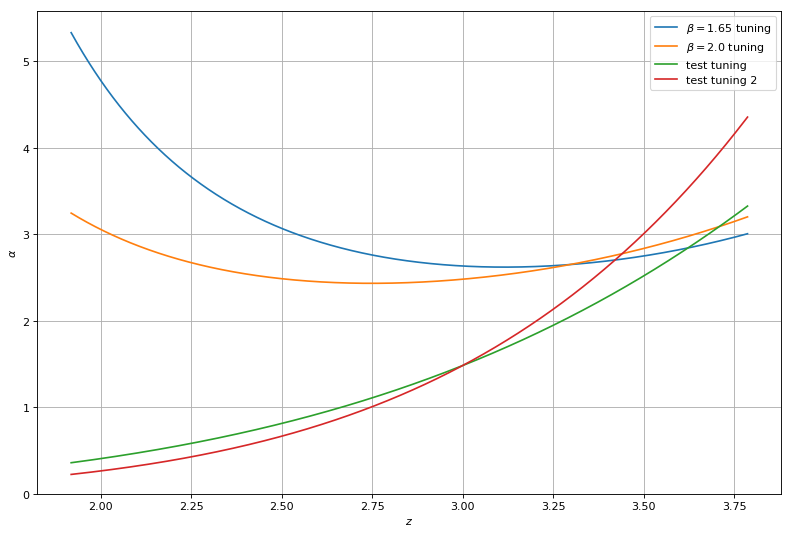

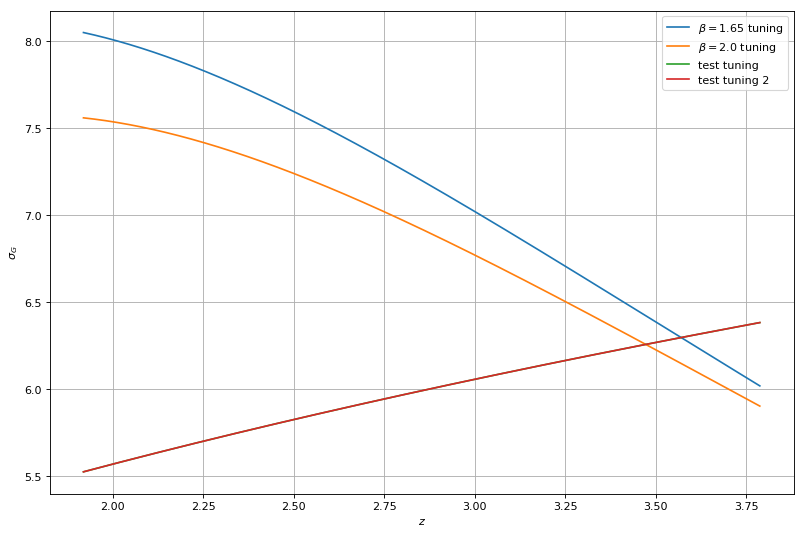

In [72]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,a_blo,label=r'$\beta=1.65$ tuning')
plt.plot(z,a_bhi,label=r'$\beta=2.0$ tuning')
plt.plot(z,a_test,label=r'test tuning')
plt.plot(z,a_test_2,label=r'test tuning 2')
plt.xlabel(r'$z$')
plt.ylabel(r'$\alpha$')
plt.ylim(ymin=0.0)
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,sG_blo,label=r'$\beta=1.65$ tuning')
plt.plot(z,sG_bhi,label=r'$\beta=2.0$ tuning')
plt.plot(z,sG_test,label=r'test tuning')
plt.plot(z,sG_test_2,label=r'test tuning 2')
plt.xlabel(r'$z$')
plt.ylabel(r'$\sigma_G$')
plt.grid()
plt.legend()
plt.show()

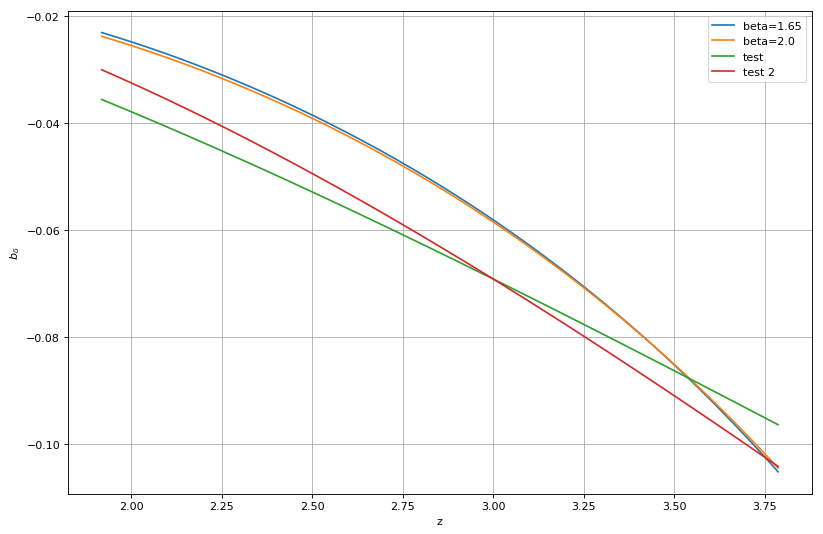

In [73]:
#Plot bias of flux for the different tuning processes
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_blo,b_blo,sG_blo,D,q='flux2')),label='beta=1.65')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_bhi,b_bhi,sG_bhi,D,q='flux2')),label='beta=2.0')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_test,b_test,sG_test,D,q='flux2')),label='test')
plt.plot(z,-np.sqrt(theoretical_bias2(z,a_test_2,b_test_2,sG_test_2,D,q='flux2')),label='test 2')
plt.xlabel('z')
plt.ylabel(r'$b_{\delta}$')
plt.grid()
plt.legend()
plt.show()

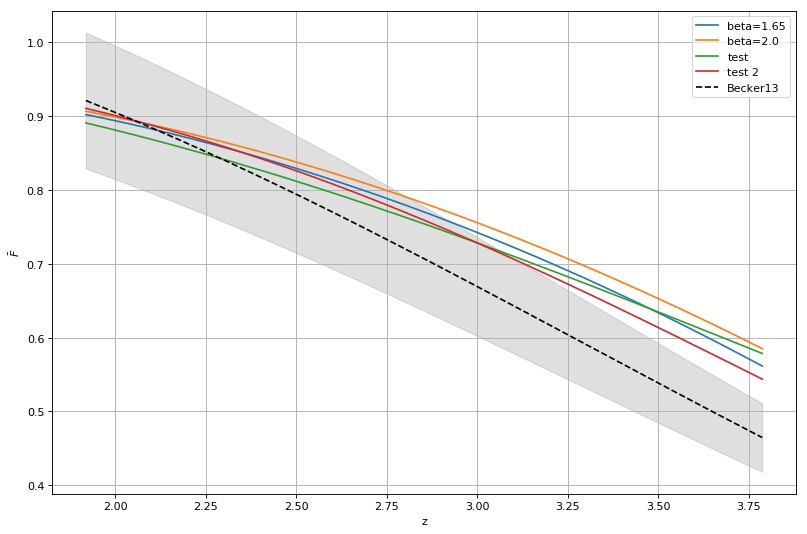

In [74]:
#Plot mean flux for the different tuning processes
from pyacolore import tuning
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(z,F_integral(z,a_blo,b_blo,sG_blo,D),label='beta=1.65')
plt.plot(z,F_integral(z,a_bhi,b_bhi,sG_bhi,D),label='beta=2.0')
plt.plot(z,F_integral(z,a_test,b_test,sG_test,D),label='test')
plt.plot(z,F_integral(z,a_test_2,b_test_2,sG_test_2,D),label='test 2')
plt.plot(z,tuning.get_mean_F_model(z),label='Becker13',linestyle='--',c='k')
plt.fill_between(z,tuning.get_mean_F_model(z)*1.1,tuning.get_mean_F_model(z)*0.9,alpha=0.25,color='gray')
plt.xlabel('z')
plt.ylabel(r'$\bar{F}$')
plt.grid()
plt.legend()
plt.show()

## Explore the variation of bias with the different parameters

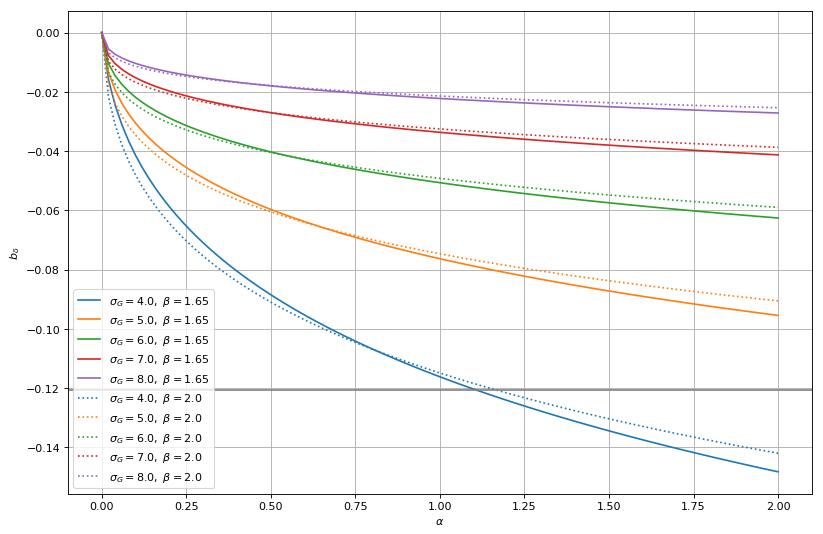

In [14]:
#Plot bias vs a for different b and sG values
z_value = 2.4
a_values = np.linspace(0.0,2.0,101)

b_values = [1.65,2.0]
linestyles = ['-',':']
sG_values = np.linspace(4.0,8.0,5)
colours = ['C0','C1','C2','C3','C4','C5','C6','C7']

d = np.interp(z_value,z,D)
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i,b in enumerate(b_values):
    for j,sG in enumerate(sG_values):
        bias = []
        for a in a_values:
            bias += [-np.sqrt(theoretical_bias2(z_value,a,b,sG,d,q='flux2'))]
        plt.plot(a_values,bias,label=r'$\sigma_G={},\ \beta={}$'.format(sG,b),c=colours[j],linestyle=linestyles[i])
plt.axhline(y=-0.1207,color='gray')
#for i,a in enumerate(a_line_values):
#    plt.axvline(x=a,color=colours[i],linestyle='--')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$b_{\delta}$')
plt.grid()
plt.legend()
plt.show()

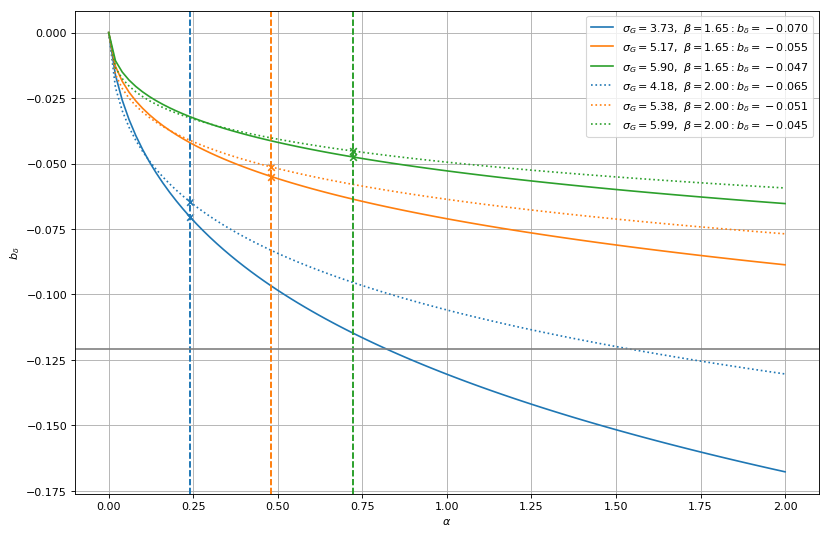

In [15]:
#Plot bias vs a for different b and sG values
z_value = 2.4
a_values = np.linspace(0.0,2.0,101)

linestyles = ['-',':'] #Used for beta values
colours = ['C0','C1','C2','C3','C4','C5','C6','C7'] #Used for sigma_G values

"""
tuning_files = []
for tuning_file in tuning_files:
    h = fits.open('../input_files/'+tuning_file)
    a = np.interp(z_value,h[1].data['z'],h[1].data['alpha'])
    b = np.interp(z_value,h[1].data['z'],h[1].data['beta'])
    s = np.interp(z_value,h[1].data['z'],h[1].data['sigma_G'])
"""

#alpha, beta index, sigma_G (all measured at z=2.4), colour index, linestyle index
parameter_sets = [(0.241, 1.65 , 3.732, 0, 0),
                  (0.481, 1.65 , 5.173, 1, 0),
                  (0.722, 1.65 , 5.899, 2, 0),
                  (0.241, 2.0  , 4.185, 0, 1),
                  (0.481, 2.0  , 5.380, 1, 1),
                  (0.722, 2.0  , 5.987, 2, 1),
                 ]


d = np.interp(z_value,z,D)
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

for i,parameter_set in enumerate(parameter_sets):
    a = parameter_set[0]
    b = parameter_set[1]
    s = parameter_set[2]
    i_c = parameter_set[3]
    i_l = parameter_set[4]
    
    bias_values = []
    for a_value in a_values:
        bias_values += [-np.sqrt(theoretical_bias2(z_value,a_value,b,s,d,q='flux2'))]
    bias_values = np.array(bias_values)[:,0].T

    bias = np.interp(a,a_values,bias_values)
    plt.scatter(a,bias,marker='x',c=colours[i_c])
    
    plt.plot(a_values,bias_values,label=r'$\sigma_G={:1.2f},\ \beta={:1.2f}: b_\delta={:1.3f}$'.format(s,b,bias),c=colours[i_c],linestyle=linestyles[i_l])
    plt.axvline(x=a,color=colours[i_c],linestyle='--')
    
#BOSS result
plt.axhline(y=-0.1207,color='gray')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$b_{\delta}$')
plt.grid()
plt.legend()
plt.show()

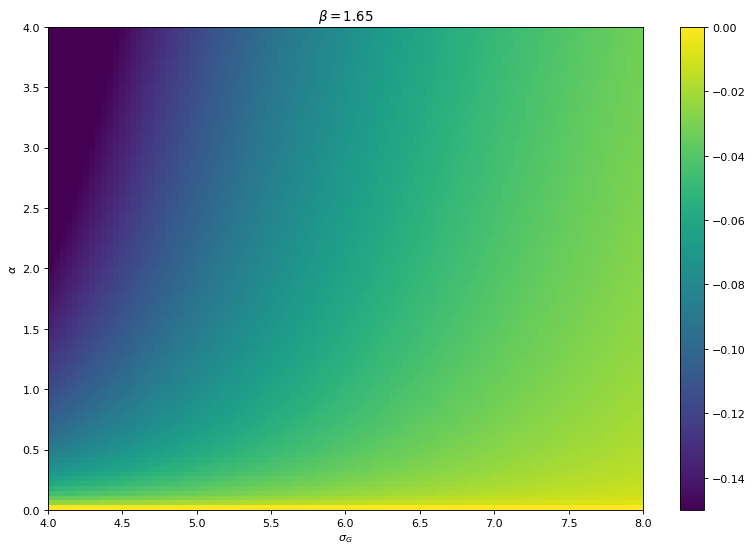

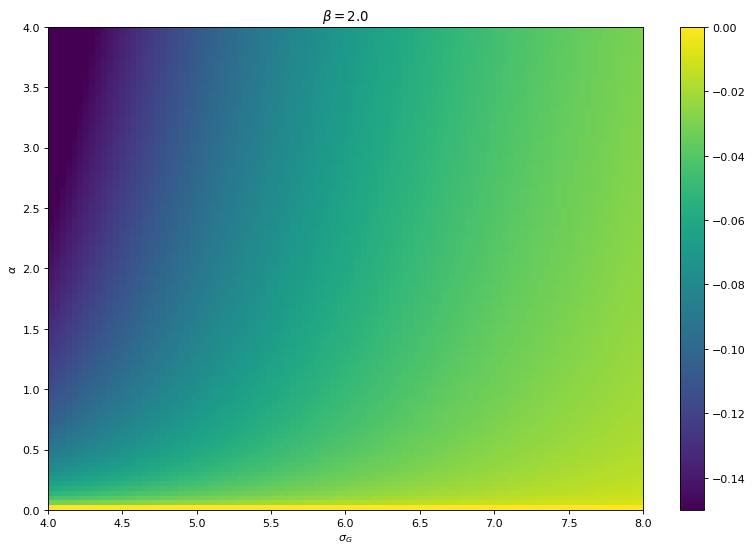

In [16]:
#Plot theoretical bias as a function of alpha and sigma_G in 2D at fixed redshift and b values
z_value = 2.4
a_values = np.linspace(0.0,4.0,101)
b_values= [1.65,2.0]
sG_values = np.linspace(4.0,8.0,101)
bias_grids = {}

d = np.interp(z_value,z,D)
for b in b_values:
    bias_grid = np.zeros((101,101))
    plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
    for i,a in enumerate(a_values):
        for j,sG in enumerate(sG_values):
            bias_grid[i,j] = -np.sqrt(theoretical_bias2(z_value,a,b,sG,d,q='flux2'))
    bias_grids[b] = bias_grid
    plt.imshow(bias_grid,aspect='auto',origin='lower',vmin=-0.15,vmax=0.,extent=[min(sG_values),max(sG_values),min(a_values),max(a_values)])
    plt.xlabel(r'$\sigma_G$')
    plt.ylabel(r'$\alpha$')
    plt.title(r'$\beta={}$'.format(b))
    plt.colorbar()
    plt.show()

/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/James/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


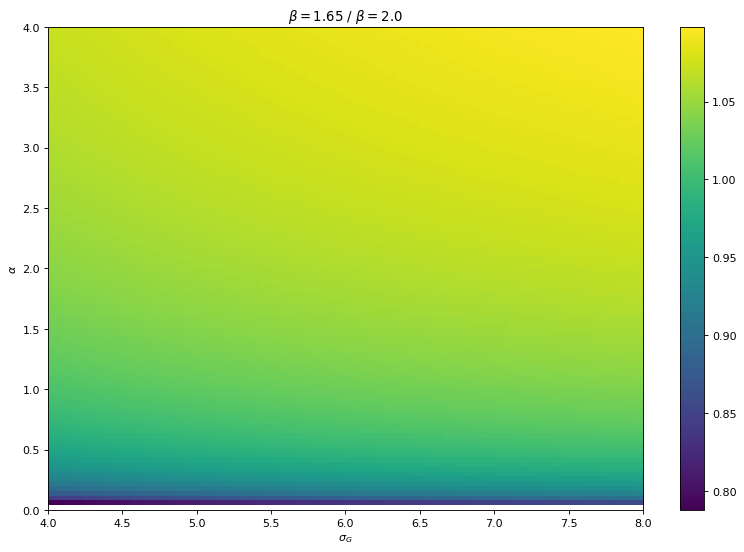

In [17]:
plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(bias_grids[1.65]/bias_grids[2.0],aspect='auto',origin='lower',extent=[min(sG_values),max(sG_values),min(a_values),max(a_values)])
plt.xlabel(r'$\sigma_G$')
plt.ylabel(r'$\alpha$')
plt.title(r'$\beta={}\ /\ \beta={}$'.format(1.65,2.0))
plt.colorbar()
plt.show()

## The above approach is not strictly correct. We actually have to marginalise over the extra gaussian field.

In [18]:
#Functions to marginalise over the additional gaussian field.
def new_get_tau(x,a,b,sG,D):
    return a*np.exp(b*D*x - 0.5*b*D*D*sG*sG)

def marginalise_tau(x,y,a,b,sG_extra,sG_colore,D):
    
    tau_x_y = (1/a)*np.outer(new_get_tau(sG_colore*y,a,b,sG_colore,D),new_get_tau(x,a,b,sG_extra,D))
    gauss_extra = np.sqrt(1/(2*np.pi*sG_extra*sG_extra)) * np.exp(-0.5*(x*x)/(sG_extra*sG_extra))
  
    tau_marginalised = np.trapz(tau_x_y*gauss_extra,x)

    return tau_marginalised

def marginalise_F(x,y,a,b,sG_extra,sG_colore,D):
    
    tau_x_y = (1/a)*np.outer(new_get_tau(sG_colore*y,a,b,sG_colore,D),new_get_tau(x,a,b,sG_extra,D))
    F_x_y = np.exp(-tau_x_y)
    gauss_extra = np.sqrt(1/(2*np.pi*sG_extra*sG_extra)) * np.exp(-0.5*(x*x)/(sG_extra*sG_extra))

    F_marginalised = np.trapz(F_x_y*gauss_extra,x)

    return F_marginalised    

In [19]:
#Function to average a 2 variable function given the pdfs of the two variables.
def average_f_dy_dx(f_x_y,x,y,p_x,p_y):
    av_dy    = np.trapz(((f_x_y).T)*p_y,y)
    av_dy_dx = np.trapz(av_dy*p_x,x)
    return av_dy_dx

In [20]:
def seljak_method(sigma,A,alpha,nu2):
    
    m = 10.
    t = np.linspace(-m*s,+m*s,1001)
    gaussian_t = np.sqrt(1/(2*np.pi*s*s)) * np.exp(-0.5*t*t/(s*s))
    delta_t = np.exp(t-0.5*s*s) - 1
    tau_t = A*(1+delta_t)**alpha
    F_t = np.exp(-tau_t)

    #mean F
    integrand = F_t
    mean_F = np.trapz(integrand*gaussian_t,t)
    print('mean_F  = {:1.4f}'.format(mean_F))

    #var F
    integrand = (F_t - mean_F)**2
    var_F = np.trapz(integrand*gaussian_t,t)
    print('var_F   = {:1.4f}'.format(var_F))

    #bias F (eqn 2.18) divided by mean density
    integrand = -(nu2*delta_t + 1.)*A*alpha*F_t*((1+delta_t)**(alpha-1)) / mean_F
    b_F = np.trapz(integrand*gaussian_t,t)
    print('b_F     = {:1.4f}'.format(b_F))

    #bias v (eqn 2.20) divided by mean density
    integrand = -tau_t*F_t / mean_F
    b_nu = np.trapz(integrand*gaussian_t,t)
    print('b_nu    = {:1.4f}'.format(b_nu))
    
    print('beta    = {:1.4f}'.format(0.9625*b_nu/b_F))
    
    return

In [21]:
def lyacolore_method(a,b,sG_extra,sG_colore,nu2):
  
    m = 10.
    x = np.linspace(-m*sG_extra,+m*sG_extra,1001)
    y = np.linspace(-m*sG_colore,+m*sG_colore,2001)

    gaussian_x = np.sqrt(1/(2*np.pi*sG_extra*sG_extra)) * np.exp(-0.5*x*x/(sG_extra*sG_extra))
    gaussian_y = np.sqrt(1/(2*np.pi*sG_colore*sG_colore)) * np.exp(-0.5*y*y/(sG_colore*sG_colore))
    
    ln_y = np.exp(D*y - 0.5*sG_colore*sG_colore*D*D)
    ln_x = np.exp(D*x - 0.5*sG_extra*sG_extra*D*D)
    ln_x_y = np.outer(ln_y,ln_x)
    delta_x_y = ln_x_y - 1

    tau_x_y = a*((1+delta_x_y)**b)
    F_x_y = np.exp(-tau_x_y)

    #LyaCoLoRe method, using Seljak numbers
    mean_F = average_f_dy_dx(F_x_y,x,y,gaussian_x,gaussian_y)
    print('mean F  = {:1.4f}'.format(mean_F))
    mean_F2 = average_f_dy_dx(F_x_y**2,x,y,gaussian_x,gaussian_y)
    print('var F   = {:1.4f}'.format(mean_F2-mean_F**2))

    #bias F (eqn 2.18) divided by mean density
    integrand = -(nu2*delta_x_y + 1.)*a*b*F_x_y*((1+delta_x_y)**(b-1)) / mean_F
    b_F = average_f_dy_dx(integrand,x,y,gaussian_x,gaussian_y)
    print('b_F     = {:1.4f}'.format(b_F))

    #bias v (eqn 2.20) divided by mean density
    #integrand = -tau_x_y*F_x_y / mean_F
    #More detailed version:
    dtau_ddl= (a*b*(1 + delta_x_y)**(b-1)) * (1 + nu2*delta_x_y)
    integrand = (- F_x_y*(tau_x_y + np.outer((ln_y - 1.),np.ones_like(x))*dtau_ddl*(1. - tau_x_y))) / mean_F
    b_nu = average_f_dy_dx(integrand,x,y,gaussian_x,gaussian_y)
    print('b_nu    = {:1.4f}'.format(b_nu))
    
    print('beta    = {:1.4f}'.format(0.9625*b_nu/b_F))
       
    """
    #Alternative method:
    #Combine the two gaussians first and go from there.
    sG = np.sqrt(sG_extra**2 + sG_colore**2)
    gaussian_x_y = np.outer(y,np.ones_like(x)) + np.outer(np.ones_like(y),x)
    delta_x_y = np.exp(D*gaussian_x_y - 0.5*sG*sG*D*D) - 1
    tau_x_y = a*((1+delta_x_y)**b)
    F_x_y = np.exp(-tau_x_y)
    
    #LyaCoLoRe method, using Seljak numbers
    mean_F = average_f_dy_dx(F_x_y,x,y,gaussian_x,gaussian_y)
    mean_F2 = average_f_dy_dx(F_x_y**2,x,y,gaussian_x,gaussian_y)
    print('mean F  = {:1.4f}'.format(mean_F))
    print('sigma F = {:1.4f}'.format(mean_F2-mean_F**2))

    #bias F (eqn 2.18) divided by mean density
    integrand = -(nu2*delta_x_y + 1.)*a*b*F_x_y*((1+delta_x_y)**(b-1)) / mean_F
    integrate_dy_dx = average_f_dy_dx(integrand,x,y,gaussian_x,gaussian_y)
    print('b_F     = {:1.4f}'.format(integrate_dy_dx))

    #bias v (eqn 2.20) divided by mean density
    integrand = -tau_x_y*F_x_y / mean_F
    integrate_dy_dx = average_f_dy_dx(integrand,x,y,gaussian_x,gaussian_y)
    print('b_nu    = {:1.4f}'.format(integrate_dy_dx))
    """
    
    return

In [22]:
#Exact recreation of Seljak (dividing by mean_F):
print('\nSeljak 2012 method (single gaussian field):')
s = 1.5
A = 0.3
alpha = 1.6
nu2 = 34./21.
seljak_method(s,A,alpha,nu2)


Seljak 2012 method (single gaussian field):
mean_F  = 0.8168
var_F   = 0.0762
b_F     = -0.1494
b_nu    = -0.1162
beta    = 0.7489


In [23]:
z_value = 2.4
m = fits.open('../example_data/lya_skewers/master.fits')
z = m[3].data['Z']
D = m[3].data['D']
m.close()
D = np.interp(z_value,z,D)

a = A
b = alpha
sG_extra = np.sqrt((1.5/D)**2 - (1.16/D)**2)
sG_colore = 1.16/D
nu2 = 34./21.

#Equivalent with LyaCoLoRe method
print('\nLyaCoLoRe method (double gaussian field):')
lyacolore_method(a,b,sG_extra,sG_colore,nu2)


LyaCoLoRe method (double gaussian field):
mean F  = 0.8168
var F   = 0.0762
b_F     = -0.1494
b_nu    = -0.0720
beta    = 0.4638


In [24]:
#alpha, beta, sigma_G (all measured at z=2.4), bias_F, beta
parameter_sets = [(0.241, 1.65 , 3.732, -0.165, 0.819),
                  (0.481, 1.65 , 5.173, -0.143, 1.063),
                  (0.722, 1.65 , 5.899, -0.127, 1.163),
                  (0.241, 2.0  , 4.185, -0.154, 0.870),
                  (0.481, 2.0  , 5.380, -0.134, 1.063),
                  (0.722, 2.0  , 5.987, -0.121, 1.142),
                  (3.264, 1.65 , 7.693, -0.114, 1.712),
                 ]

#LyaCoLoRe method with different tunings
for parameter_set in parameter_sets:
    a = parameter_set[0]
    b = parameter_set[1]
    s = parameter_set[2]
    m_bd = parameter_set[3]
    m_beta = parameter_set[4]
    m_bn = m_beta * m_bd / 0.9625
    sG_extra = np.sqrt(s**2 - sG_colore**2)
    
    print('a={:1.3f}, b={:1.3f}, sG={:1.3f}'.format(a,b,s))
    lyacolore_method(a,b,sG_extra,sG_colore,1.0)
    print('b_F mea  = {:1.3f}'.format(m_bd))
    print('b_nu mea = {:1.3f}'.format(m_bn))
    print('beta mea = {:1.3f}'.format(m_beta))
    print(' ')

a=0.241, b=1.650, sG=3.732
mean F  = 0.8256
var F   = 0.0695
b_F     = -0.1906
b_nu    = -0.0608
beta    = 0.3071
b_F mea  = -0.165
b_nu mea = -0.140
beta mea = 0.819
 
a=0.481, b=1.650, sG=5.173
mean F  = 0.8254
var F   = 0.0876
b_F     = -0.1487
b_nu    = -0.0691
beta    = 0.4470
b_F mea  = -0.143
b_nu mea = -0.158
beta mea = 1.063
 
a=0.722, b=1.650, sG=5.899
mean F  = 0.8326
var F   = 0.0905
b_F     = -0.1285
b_nu    = -0.0653
beta    = 0.4891
b_F mea  = -0.127
b_nu mea = -0.153
beta mea = 1.163
 
a=0.241, b=2.000, sG=4.185
mean F  = 0.8344
var F   = 0.0824
b_F     = -0.1750
b_nu    = -0.0524
beta    = 0.2883
b_F mea  = -0.154
b_nu mea = -0.139
beta mea = 0.870
 
a=0.481, b=2.000, sG=5.380
mean F  = 0.8378
var F   = 0.0923
b_F     = -0.1388
b_nu    = -0.0548
beta    = 0.3796
b_F mea  = -0.134
b_nu mea = -0.148
beta mea = 1.063
 
a=0.722, b=2.000, sG=5.987
mean F  = 0.8437
var F   = 0.0934
b_F     = -0.1223
b_nu    = -0.0520
beta    = 0.4089
b_F mea  = -0.121
b_nu mea = -0.144
beta 

In [25]:
def F_bias2_2d(a,b,sG_extra,sG_colore,D,N_pow=3,tau_method=None):
    
    m = 10.
    x = np.linspace(-m*sG_extra,+m*sG_extra,1001)
    y = np.linspace(-m*sG_extra,+m*sG_extra,2001)

    gaussian_x = np.sqrt(1/(2*np.pi*sG_extra*sG_extra)) * np.exp(-0.5*x*x/(sG_extra*sG_extra))
    gaussian_y = np.sqrt(1/(2*np.pi*sG_colore*sG_colore)) * np.exp(-0.5*y*y/(sG_colore*sG_colore))

    ln_y = np.exp(D*y - 0.5*sG_colore*sG_colore*D*D)
    ln_x = np.exp(D*x - 0.5*sG_extra*sG_extra*D*D)
    ln_x_y = np.outer(ln_y,ln_x)
    delta_x_y = ln_x_y - 1
        
    tau_y = new_get_tau(y,a,b,sG_colore,D)
    tau_x = new_get_tau(x,a,b,sG_extra,D)

    #tau_x_y = (1/a)*np.outer(tau_y,tau_x)
    tau_x_y = a*((1+delta_x_y)**b)
    F_x_y = np.exp(-tau_x_y)
    
    mean_F = average_f_dy_dx(F_x_y,x,y,gaussian_x,gaussian_y)
    mean_F2 = average_f_dy_dx(F_x_y**2,x,y,gaussian_x,gaussian_y)
    bias2 = (b*average_f_dy_dx(F_x_y*tau_x_y,x,y,gaussian_x,gaussian_y)/mean_F)**2
    
    return bias2

In [26]:
def bias_seljak(a,b,sG_extra,sG_colore,d,nu2,option='F'):
  
    m = 10.
    x = np.linspace(-m*sG_extra,+m*sG_extra,1001)
    y = np.linspace(-m*sG_colore,+m*sG_colore,2001)

    gaussian_x = np.sqrt(1/(2*np.pi*sG_extra*sG_extra)) * np.exp(-0.5*x*x/(sG_extra*sG_extra))
    gaussian_y = np.sqrt(1/(2*np.pi*sG_colore*sG_colore)) * np.exp(-0.5*y*y/(sG_colore*sG_colore))
    
    ln_y = np.exp(d*y - 0.5*sG_colore*sG_colore*d*d)
    ln_x = np.exp(d*x - 0.5*sG_extra*sG_extra*d*d)
    ln_x_y = np.outer(ln_y,ln_x)
    delta_x_y = ln_x_y - 1
    #plt.loglog(x,ln_x)
    #plt.loglog(x,np.trapz(ln_x_y.T,y))
    #plt.show()
    
    tau_x_y = a*((1+delta_x_y)**b)
    F_x_y = np.exp(-tau_x_y)

    mean_F = average_f_dy_dx(F_x_y,x,y,gaussian_x,gaussian_y)

    if option == 'F':
        #bias F (eqn 2.18) divided by mean F
        integrand = -(nu2*delta_x_y + 1.)*a*b*F_x_y*((1+delta_x_y)**(b-1)) / mean_F
        #integrand = -(nu2*np.outer(np.ones_like(y),ln_x-1.) + 1.)*a*b*F_x_y*((1+delta_x_y)**(b-1)) / mean_F
    elif option == 'nu':
        #bias nu (eqn 2.20) divided by mean F
        #integrand = (-tau_x_y*F_x_y)/ mean_F
        
        #bias nu (eqn 2.20) divided by mean F, same order in d_l but not taking mean too early (?), as in (2.16)
        #2 options for dtau_ddl, one letting ds = d as the paper does on p4, one not
        #dtau_ddl= (a*b*(1 + delta_x_y)**(b-1)) * (1 + nu2*np.outer(np.ones_like(y),(ln_x - 1.)))
        dtau_ddl= (a*b*(1 + delta_x_y)**(b-1)) * (1 + nu2*delta_x_y)
        integrand = (- F_x_y*(tau_x_y + np.outer((ln_y - 1.),np.ones_like(x))*dtau_ddl*(1. - tau_x_y))) / mean_F
        #integrand = (-tau_x_y*F_x_y - a*b*F_x_y*((1+delta_x_y)**(b-1))*np.outer(ln_y,1+nu2*ln_x)*(1-tau_x_y)) / mean_F
        
        #bias nu from original method?
        #gamma = 1.
        #integrand = - gamma * d * np.outer(ln_y - 1,np.ones_like(x)) * (b*sG_colore + 1.) * tau_x_y * F_x_y / (mean_F)
        
    bias = (average_f_dy_dx(integrand,x,y,gaussian_x,gaussian_y))

    return bias

In [27]:
bias_seljak(0.241,1.65,np.sqrt(3.732**2-sG_colore),sG_colore,d,nu2,option='F')

-0.12188993584633181

In [28]:
print('old b_F = {:1.4f}'.format(-np.sqrt(F_bias2_2d(a,b,sG_extra,sG_colore,d))))

old b_F = -0.0955


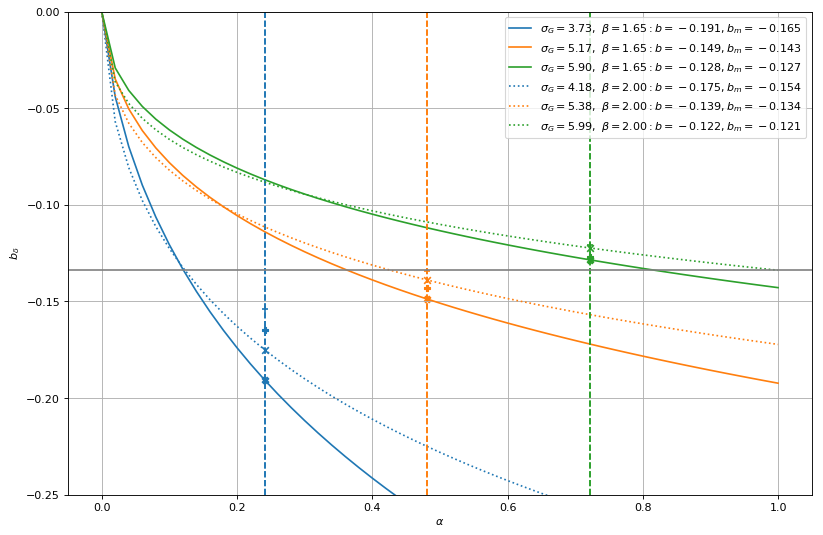

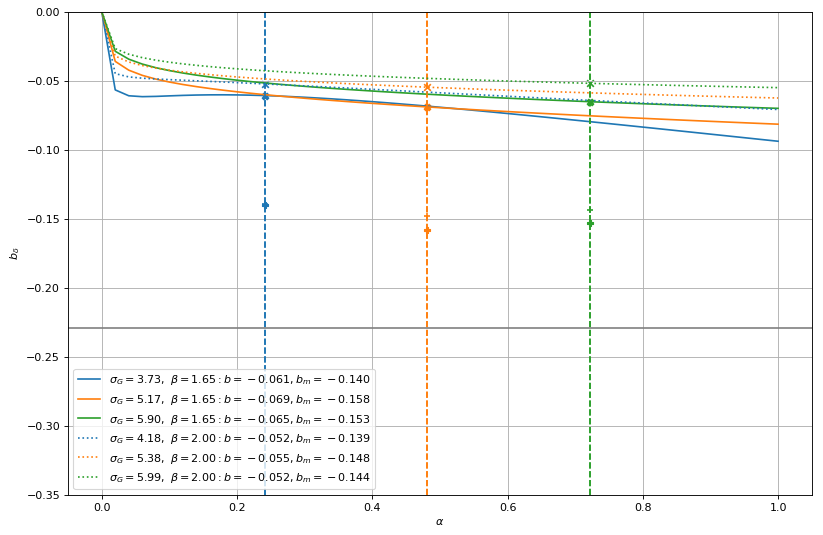

In [36]:
#Plot bias vs a for different b and sG values
z_value = 2.4
a_values = np.linspace(0.0,1.0,51)
bias_options = ['F','nu']
nu2 = 1.0

m = fits.open('../example_data/lya_skewers/master.fits')
z = m[3].data['Z']
D = m[3].data['D']
m.close()

linestyles = ['-',':'] #Used for beta values
theory_markers = ['X','x']
measured_markers = ['P','+']
colours = ['C0','C1','C2','C3','C4','C5','C6','C7'] #Used for sigma_G values

#alpha, beta, sigma_G (all measured at z=2.4), colour index, linestyle index
parameter_sets = [(0.241, 1.65 , 3.732, 0, 0, -0.165, 0.819),
                  (0.481, 1.65 , 5.173, 1, 0, -0.143, 1.063),
                  (0.722, 1.65 , 5.899, 2, 0, -0.127, 1.163),
                  (0.241, 2.0  , 4.185, 0, 1, -0.154, 0.870),
                  (0.481, 2.0  , 5.380, 1, 1, -0.134, 1.063),
                  (0.722, 2.0  , 5.987, 2, 1, -0.121, 1.142),
                 ]

mean_F_RSD_diffs = [0.39, -0.68, -0.97, -0.23, -1.11, -1.30]
        
d = np.interp(z_value,z,D)


for bias_option in bias_options:

    plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

    for i,parameter_set in enumerate(parameter_sets):
        a = parameter_set[0]
        b = parameter_set[1]
        s = parameter_set[2]
        i_c = parameter_set[3]
        i_l = parameter_set[4]
        m_bd = parameter_set[5]
        m_beta = parameter_set[6]
        m_bn = m_beta * m_bd / 0.9625

        sG_extra = np.sqrt(s**2 - sG_colore**2)

        #Factor to correct for difference in mean F due to RSDs?
        factor = 1./(1 + mean_F_RSD_diffs[i]/100.)

        bias_values = []
        for a_value in a_values:
            #Oldest version, 1d, scaled to take D out, v quick
            #bias_values += [-np.sqrt(theoretical_bias2(z_value,a_value,b,s,d,q='flux2'))/d]

            #Updated to do 2d integration (D already removed)
            #bias_values += [-np.sqrt(F_bias2_2d(a_value,b,sG_extra,sG_colore,d))]

            #Updated to use Seljak 2012 nu2 (1.0 matches previous)
            bias_values += [bias_seljak(a_value,b,sG_extra,sG_colore,d,nu2,option=bias_option)]

        bias_values = np.array(bias_values)
        #bias_values = np.array(bias_values)[:,0].T

        bias = np.interp(a,a_values,bias_values)
        plt.scatter(a,bias,marker=theory_markers[i_l],c=colours[i_c])

        if bias_option == 'F':
            bias_measured = m_bd
        elif bias_option == 'nu':
            bias_measured = m_bn

        plt.scatter(a,bias_measured,marker=measured_markers[i_l],c=colours[i_c])

        plt.plot(a_values,bias_values,label=r'$\sigma_G={:1.2f},\ \beta={:1.2f}: b={:1.3f}, b_m={:1.3f}$'.format(s,b,bias,bias_measured),c=colours[i_c],linestyle=linestyles[i_l])
        plt.axvline(x=a,color=colours[i_c],linestyle='--')

    #BOSS result
    if bias_option == 'F':
        plt.axhline(y=-0.1336,color='gray')
        plt.ylim(-0.25,0.0)
    elif bias_option == 'nu':
        plt.axhline(y=-0.2293,color='gray')
        plt.ylim(-0.35,0.0)

    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$b_{\delta}$')
    plt.grid()
    plt.legend()
    plt.show()